# This test is to generate Confidence Intervals for model Prediction.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\kregh\AppData\Local\Temp\ipykernel_24020\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
data = data.sample(n=10000)

In [9]:
import time

In [10]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    6916
1    1084
Name: count, dtype: int64
Test label
0    1753
1     247
Name: count, dtype: int64


In [11]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# Some error when sampling need to set to .values
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
time.sleep(20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/'
model = NNdynamic(n_features, fc_size, device, save_dir)
model.load_model('./Models/saved_models/02/smote/01-256/PB_epoch_5.pth')


c:\Users\kregh\OneDrive - University of South Australia\2025_Capstone Project\VS Code\UniSA_ICT_2025-SP1-P4-Explainable-AI-for-Cyber-Threat-Detection\Models\models.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any is

In [13]:
def predict_binary_uncertainty(f_model, data_loader, n_iterations=100, device='cpu'):
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    f_model.to(device)
    f_model.train()
    preds = []

    with torch.no_grad():
        for _ in range(n_iterations):
            batch_preds = []
            for X_batch, _ in data_loader:
                X_batch - X_batch.to(device)
                output = model(X_batch).sigmoid()
                batch_preds.append(output.cpu().numpy())
            preds.append(np.vstack(batch_preds))
        
    preds = np.array(preds).squeeze(axis=-1)
            
    mean_prob = preds.mean(axis=0)
    std_dev = preds.std(axis=0)
    return mean_prob, std_dev

In [14]:
mean_pred, std_pred = predict_binary_uncertainty(model, test_loader)
ci_lower = mean_pred - 1.96 * std_pred
ci_upper = mean_pred + 1.96 * std_pred

In [21]:
predicted_class = (mean_pred >= 0.5).astype(int)
is_uncertain = (ci_lower <0.45) & (ci_upper > 0.55)

results = pd.DataFrame({
    'mean_prob': mean_pred,
    'std_dev' : std_pred,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper,
    'predicted_class': predicted_class,
    'is_uncertain': is_uncertain
})

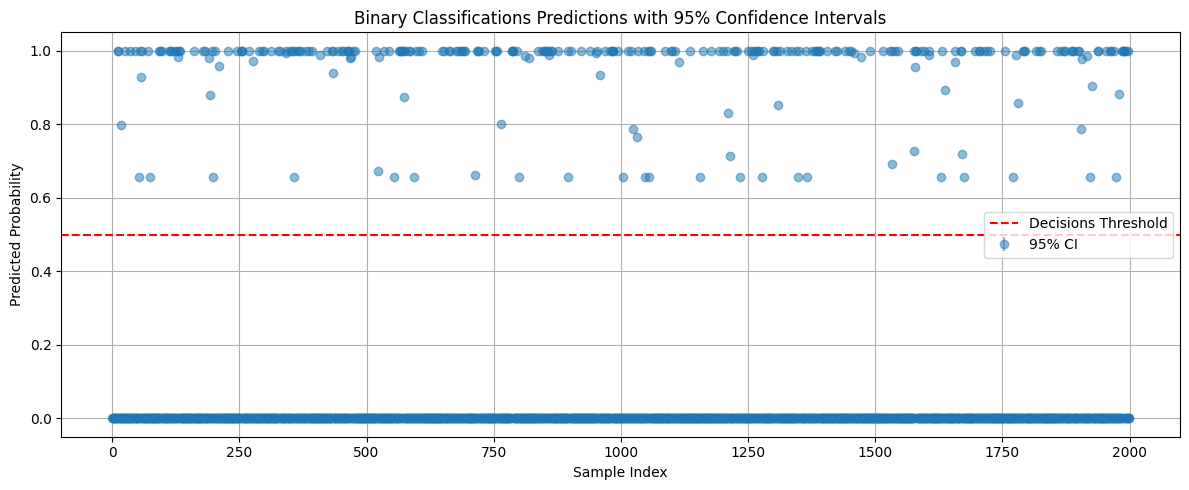

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 5))
x = range(len(mean_pred))

plt.errorbar(x, mean_pred, yerr=1.96 * std_pred, fmt = 'o', alpha=0.5, label='95% CI')
plt.axhline(0.5, color='red', linestyle='--', label='Decisions Threshold')
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability")
plt.title("Binary Classifications Predictions with 95% Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
uncertain_count = is_uncertain.sum()
total = len(mean_pred)

print(f"Uncertain predictions: {uncertain_count}/{total} ({uncertain_count / total:.2%})")

Uncertain predictions: 0/2000 (0.00%)
